## Initializing SparkSession with Hive Support


In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Checking_Model") \
    .enableHiveSupport() \
    .getOrCreate()

## Importing Required Libraries for Data Processing and Model Evaluation


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score,confusion_matrix,classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 

## Reading Data from Hive Table into a Spark DataFrame


In [3]:
#  Define the Hive table name
hive_table = "flight_db.flight_data_partitioned_month"

#  Read the Hive table into a Spark DataFrame
df_spark = spark.sql(f"SELECT * FROM {hive_table}")

## Sampling 5% of Data for Each Month from the Hive Table


In [4]:
# Get the unique months available in the data
months = df_spark.select("Month").distinct().collect()
print(months)
# Sample 5% data for each month
df_monthly_sampled = None

for month in months:
    month_data = df_spark.filter(df_spark.Month == month["Month"]) \
                         .sample(withReplacement=False, fraction=0.05, seed=4321)
    
    # Union the monthly sampled data
    if df_monthly_sampled is None:
        df_monthly_sampled = month_data
    else:
        df_monthly_sampled = df_monthly_sampled.union(month_data)

# Show the first 5 rows of the sampled data
df_monthly_sampled.show(5)

[Row(Month='7'), Row(Month='11'), Row(Month='3'), Row(Month='8'), Row(Month='5'), Row(Month='6'), Row(Month='9'), Row(Month='1'), Row(Month='10'), Row(Month='4'), Row(Month='12'), Row(Month='2')]
+----+-------+----------+---------+----------+-------------------------+---------------------------------------+------------------------+---------------------------+-------------------------------+-----------------+------------------------+---------------------------+-------------------------------+---------------+------------------+------------------+------+---------------+-----------+---------------+---------------+---------+-------------+----------------+----------------+----+---------------+---------+-------------+-------------+-------+----------+-------+--------+---------------+--------+--------------------+----------+-------+---------+--------+------+----------+-------+--------+---------------+--------+------------------+----------+---------+--------+--------------+-----------------+----

## Converting Spark DataFrame to Pandas DataFrame


In [5]:
df=df_monthly_sampled.toPandas()

## Selecting Relevant Features and Target Variable for Prediction


In [6]:
# Select relevant features
features = ['Month', 'DayOfWeek', 'DepTimeBlk', 'Origin', 'Dest', 'Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','TaxiOut', 'TaxiIn']
target = 'DepDel15'  # Binary classification (1 = delay >= 15 min, 0 = no delay)

## Separating Features and Target Variable for Model Training


In [7]:
# Separate features and target variable
X = df[features]
y = df[target].astype(int)  # Ensure binary classification

## Identifying Numerical and Categorical Features


In [8]:
# Identify numerical and categorical features
num_features = ['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay','TaxiOut', 'TaxiIn']
cat_features = ['Month', 'DayOfWeek', 'DepTimeBlk', 'Origin', 'Dest']

## Defining the Preprocessing Pipeline for Features


In [9]:
# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

## Creating the Machine Learning Pipeline


In [10]:
# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
])

## Splitting the Dataset into Training and Testing Sets


In [11]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [18]:
import pickle

with open('logistic_rs_model.pkl','rb') as f:
    loaded_Lr = pickle.load(f)

## Loading the Pre-trained Logistic Regression Model


In [20]:
y_pred_lr = loaded_Lr.predict(X_test)

## Evaluating the Logistic Regression Model's Performance


In [23]:
# Model evaluation

precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)
accuracy = accuracy_score(y_test, y_pred_lr)

print(f'Accuracy: {accuracy:.4f}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9449
Precision: 0.8886
Recall: 0.8063
F1-score: 0.8455


## Loading the Pre-trained LGBM Model


In [26]:
import pickle

with open('best_lgbm_model.pkl','rb') as f:
    loaded_Lgbm = pickle.load(f)

## Making Predictions with the Loaded LGBM Model


In [27]:
y_pred_lgbm = loaded_Lgbm.predict(X_test)

## Evaluating the LGBM Model's Performance


In [28]:
# Model evaluation

precision = precision_score(y_test, y_pred_lgbm)
recall = recall_score(y_test, y_pred_lgbm)
f1 = f1_score(y_test, y_pred_lgbm)
accuracy = accuracy_score(y_test, y_pred_lgbm)

print(f'Accuracy: {accuracy:.4f}')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.9587
Precision: 0.9851
Recall: 0.7912
F1-score: 0.8775


## Comparing Accuracy Between LGBM and Logistic Regression Models


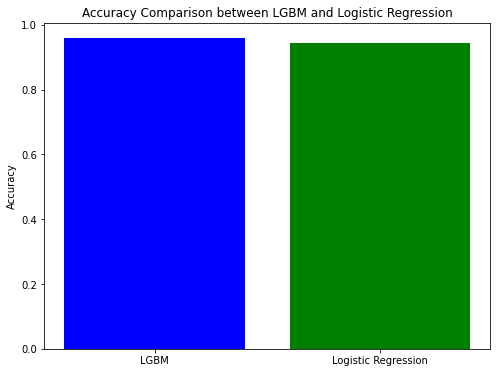

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns

# Assuming `y_test` is your true labels

# 1. Accuracy Comparison Bar Chart
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_lr = accuracy_score(y_test, y_pred_lr)

plt.figure(figsize=(8, 6))
plt.bar(['LGBM', 'Logistic Regression'], [accuracy_lgbm, accuracy_lr], color=['blue', 'green'])
plt.title('Accuracy Comparison between LGBM and Logistic Regression')
plt.ylabel('Accuracy')
plt.show()

## Plotting and Comparing Confusion Matrices for LGBM and Logistic Regression


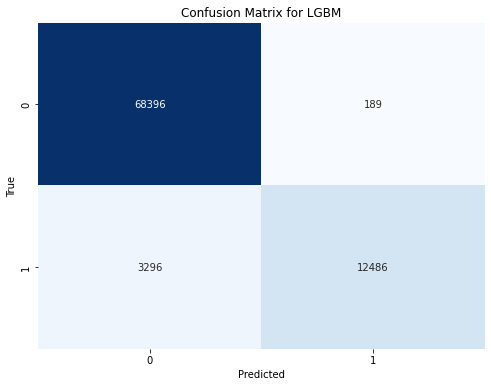

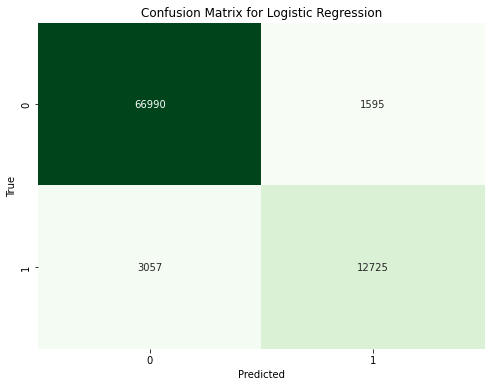

In [31]:
#  Confusion Matrix for both models
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Plotting confusion matrix for LGBM
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for LGBM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plotting confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


## Comparing ROC Curves for LGBM and Logistic Regression Models


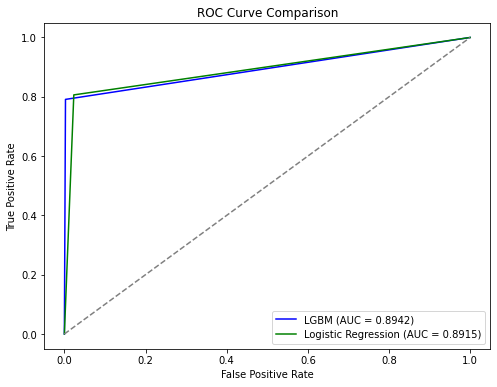

In [34]:
# 3. ROC Curve Comparison
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, y_pred_lgbm)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', label=f'LGBM (AUC = {roc_auc_lgbm:.4f})')
plt.plot(fpr_lr, tpr_lr, color='green', label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [ ]:
spark.stop()